# 第六题 验证假设 展示绩效

信号假设：结合两个情绪类技术因子（ARJ以及PSYJ），对这两个因子的均线上穿或下穿事件进行打分加总，若相乘及加总后的分数高于或低于一定阈值，则买卖信号出现

（1）进场信号： long:当因子的短期均线向上穿过长期均线以及前四小时的短期均线在长期均线下方时，记1分，加总相乘后的分数若高于120分时下多单。 short:当短期均线向下穿过长期均线以及前四小时的短期均线在长期均线上方时，记-1分，当加总相乘后分数低于90分时下空单。

（2）出场信号： close_long：判断当前市场是否出现新的信号可以开空单，如果空单信号出现，就平掉原来的多仓，否则继续持有多仓。 close_short：判断当前市场是否出现新的信号可以开多单，如果多单信号出现，就平掉原来的空仓，否则继续持有空仓。

### 测试该策略应用于BTCUSDT:binance的表现

In [1]:
# 1、 载入数据，分析品种为BTCUSDT:binance，周期为4小时，起始时间为2018年6月1日
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jaqs_fxdayu.data.hf_dataview import HFDataView

warnings.filterwarnings('ignore')
ds = LocalDataService()
start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '4H',
         'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)

In [2]:
dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [3]:
def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,7))
    ax.plot(close)
    ax.set_title('4H_price_time_series')
    ax1.plot(alpha)
    ax1.set_title('factor_time_series')
    plt.show()

In [4]:
def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,7))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    plt.show()

def Scale(df,k=1):
    return df.mul(k).div(np.abs(df).sum())

def RankPct(df):
    return df.rank(axis=1, pct=True)

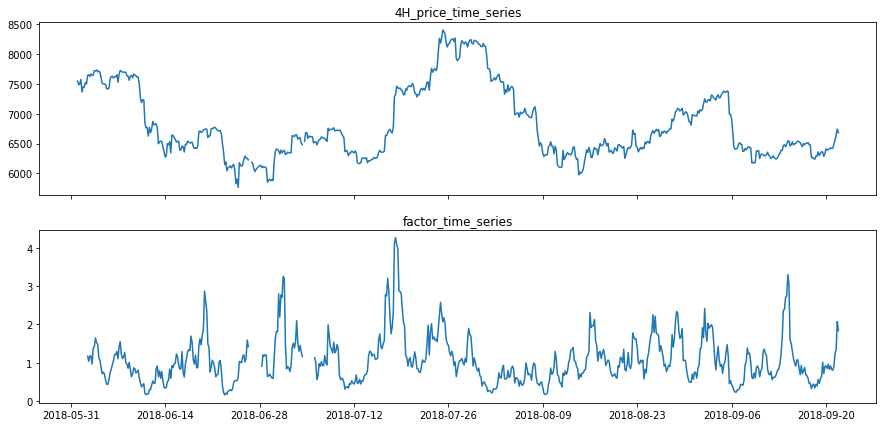

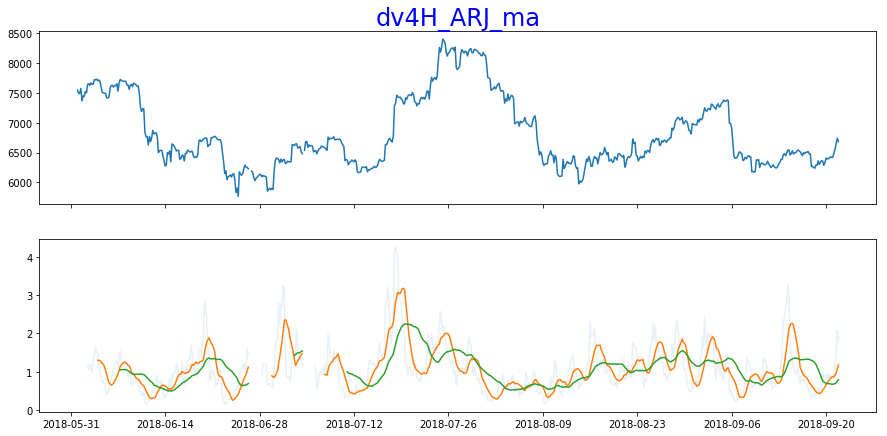

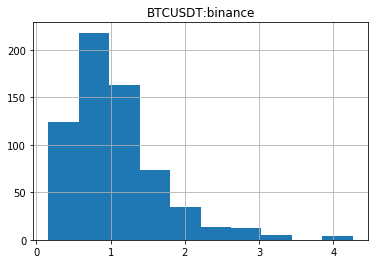

symbol,BTCUSDT:binance
count,648.000000
mean,1.070109
std,0.620969
min,0.162470
25%,0.641234
50%,0.945664
75%,1.312006
max,4.263777


In [5]:
# 2、画图观察因子
#（1）技术因子 - 情绪类 AR G010001A，即ARJ
dv.add_formula("AR_J", "Ts_Sum(high-open,10)/Ts_Sum(open-low,10)", add_data=True)
close = dv.get_ts('close', date_type='datetime')
AR_J = dv.get_ts('AR_J',date_type='datetime').iloc[:,0]
plot_chart(close,AR_J)                                                            # 画出因子走势图
Plot_Mean(dv, AR_J, chart_name='dv4H_ARJ_ma', ShortPeriod=10, LongPeriod=30, n=0) # 对因子走势图作平滑处理，进行观察
dv.get_ts("AR_J").hist()                                                          # 画出因子频率分布直方图
plt.show()
dv.get_ts("AR_J").describe()                                                      # 因子的描述性统计

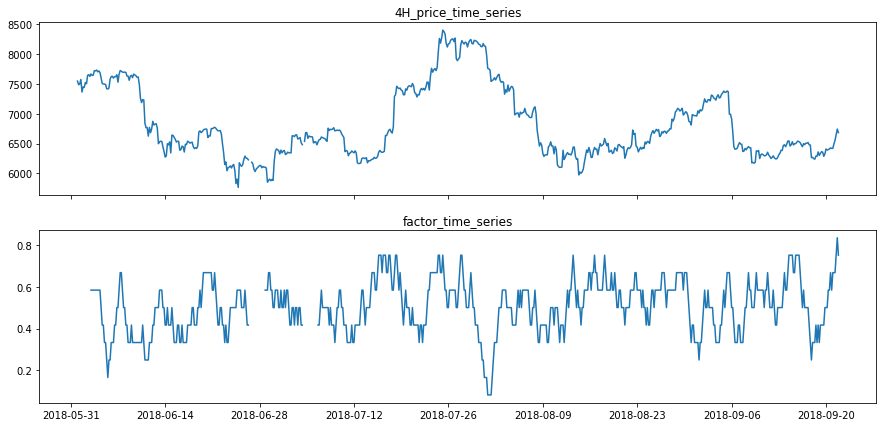

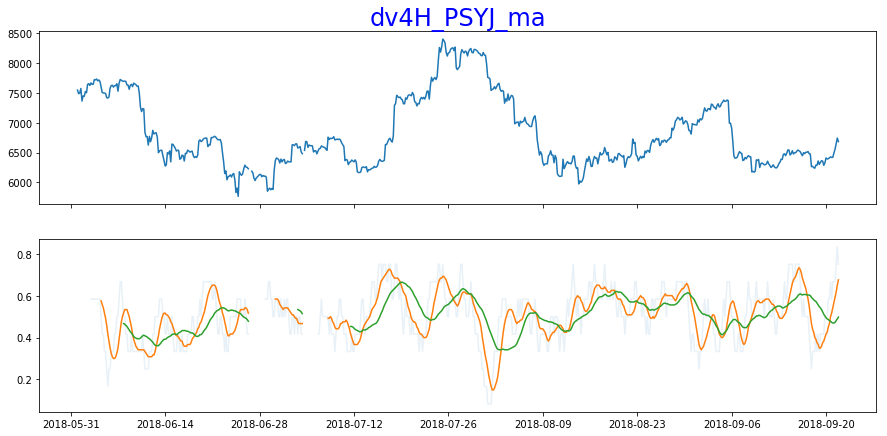

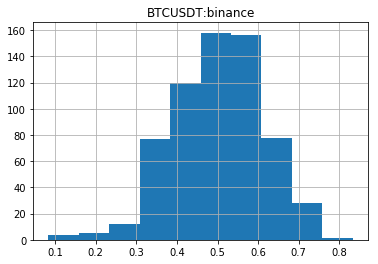

symbol,BTCUSDT:binance
count,639.000000
mean,0.506521
std,0.125547
min,0.083333
25%,0.416667
50%,0.500000
75%,0.583333
max,0.833333


In [6]:
# （2）画图观察另一个情绪类技术因子，PSY_J
close = dv.get_ts('close', date_type='datetime')
dv.add_formula("PSY_J", "Ts_Sum(close>Delay(close,1),12)/12", add_data=True)
PSY_J = dv.get_ts('PSY_J',date_type='datetime')
plot_chart(close,PSY_J)                                                                                # 画出因子走势图
Plot_Mean(dv, PSY_J['BTCUSDT:binance'], chart_name='dv4H_PSYJ_ma', ShortPeriod=10, LongPeriod=30, n=0) # 对因子作平滑处理，进行观察
dv.get_ts("PSY_J").hist()                                                                              # 画出因子分布图
plt.show()
dv.get_ts("PSY_J").describe()                                                                          # 因子的描述性统计

In [7]:
# 3 对因子的均线上穿下穿事件进行打分
# （1）定义得分函数
def calculate(close, timePeriod):
    mas = ta.MA(close.iloc[:,0].values, timePeriod)
    mal = ta.MA(close.iloc[:,0].values, 5*timePeriod)
    df = pd.DataFrame({'long': mal, 'short': mas}, index=close.index).dropna()
    df['direction'] = list(map(lambda s, l: 1 if s>l else 0, df['short'], df['long']))
    return df['direction']

In [8]:
#（2）打分
import talib as ta
factor = dv.get_ts('AR_J',date_type='datetime').dropna()
x = np.array(range(1,21,1))
signalDf_ARJ = pd.DataFrame({t: calculate(factor, t) for t in x})
signalDf_ARJ['signal'] = pd.Series({name: true.sum()*5 for name, true in signalDf_ARJ.iterrows()})

factor = dv.get_ts('PSY_J',date_type='datetime').dropna()
x = np.array(range(1,21,1))
signalDf_PSYJ = pd.DataFrame({t: calculate(factor, t) for t in x})
signalDf_PSYJ['signal'] = pd.Series({name: true.sum()*5 for name, true in signalDf_PSYJ.iterrows()})

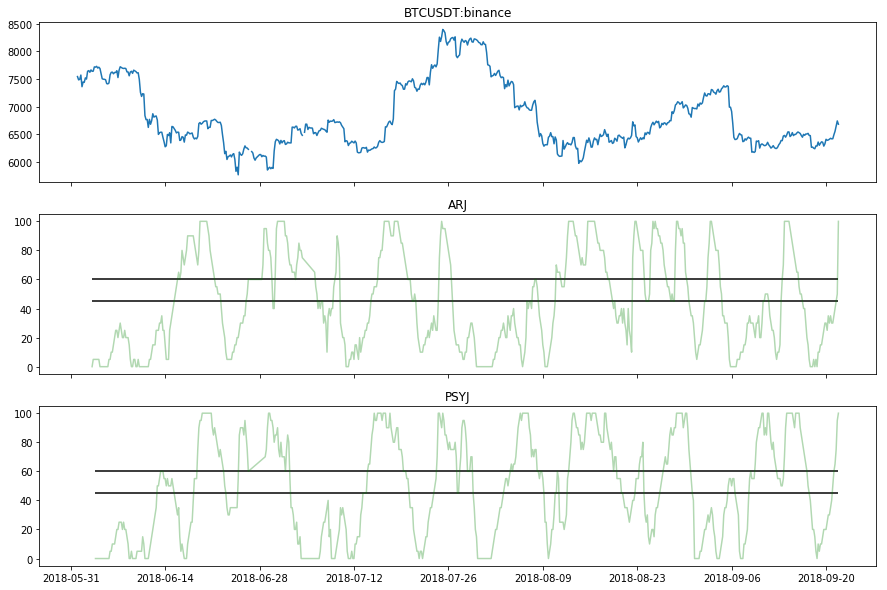

In [9]:
#（3）画出两个因子的得分情况
import matplotlib.pyplot as plt
from talib import abstract

fig, (ax,ax1,ax2) = plt.subplots(3,1,sharex=True, figsize=(15,10))
ax.plot(dv.get_ts('close',date_type='datetime'))
ax.set_title('BTCUSDT:binance')
ax1.plot(signalDf_ARJ['signal'], 'g', alpha=0.3)
ax1.hlines(60, signalDf_ARJ['signal'].index[0], signalDf_ARJ['signal'].index[-1])
ax1.hlines(45, signalDf_ARJ['signal'].index[0], signalDf_ARJ['signal'].index[-1])
ax1.set_title('ARJ')
ax2.plot(signalDf_PSYJ['signal'], 'g', alpha=0.3)
ax2.hlines(60, signalDf_PSYJ['signal'].index[0], signalDf_PSYJ['signal'].index[-1])
ax2.hlines(45, signalDf_PSYJ['signal'].index[0], signalDf_PSYJ['signal'].index[-1])
ax2.set_title('PSYJ')
plt.show()

In [10]:
def signalAppend(signalDf,name):
    signalDf['time'] = signalDf.index
    signalDf["trade_date"] = signalDf['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    signalDf["symbol"] = "BTCUSDT:binance"
    signalDf = signalDf.set_index(["trade_date","symbol"])
    signalSe = signalDf.signal.unstack()
    signalname = 'signalSe'+'_'+name
    dv.append_df(signalSe,signalname)
signalAppend(signalDf_ARJ,'ARJ')
signalAppend(signalDf_PSYJ,'PSYJ')

In [11]:
# 4、定义进出场信号
# 进场信号为ARJ与PSYJ得分之和上穿120分线时刻，出场信号为ARJ与PSYJ得分之和下穿90分线时刻
long = dv.add_formula('long','If((signalSe_ARJ+signalSe_PSYJ>=120) && (Delay((signalSe_ARJ+signalSe_PSYJ),1)<120), 2, 0)', add_data=True)
short = dv.add_formula('short','If((signalSe_ARJ+signalSe_PSYJ<=90) && (Delay((signalSe_ARJ+signalSe_PSYJ),1)>90), -2, 0)', add_data=True)
closeLong = dv.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

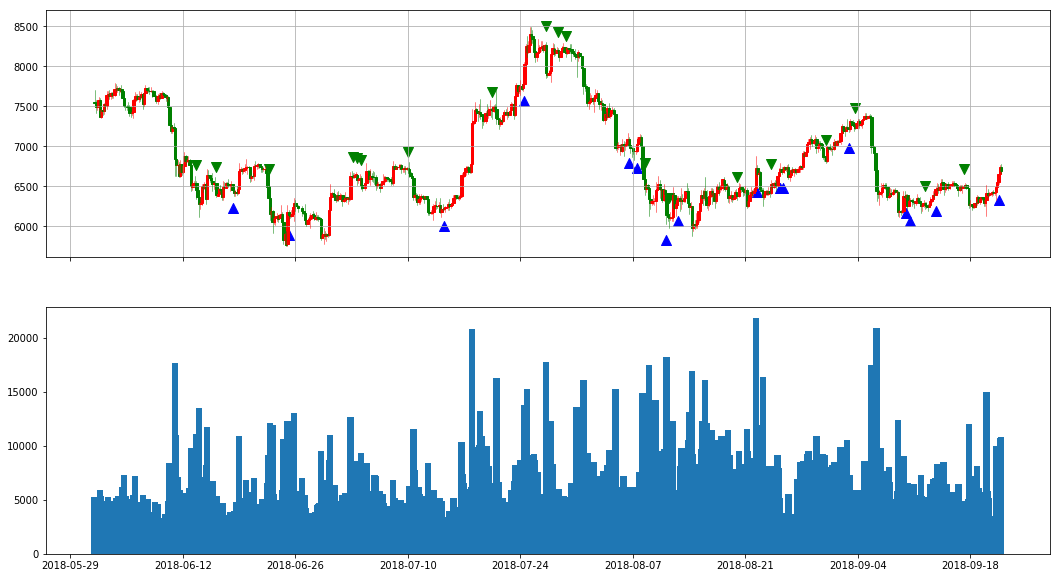

In [12]:
# 5、在k线图中画出进出场信号产生的时刻
import mpl_finance as mpf

def draw_candle_signal(candle, longX, longY,shortX,shortY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(longX, longY, color='b', s=100, marker='^')
    ax.scatter(shortX,shortY,color='g',s=100,marker='v')
    ax.xaxis_date ()
    ax1.bar(data4H.index, data4H.volume)
    plt.show()

from matplotlib.pylab import date2num

data4H = Time_dict.set_index('datetime')
data4H['candleTime'] = list(map(date2num, data4H.index))
candle = data4H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

longsignal = dv.get_ts('long', date_type='datetime')
shortsignal = dv.get_ts('short', date_type='datetime')

longX = longsignal[longsignal['BTCUSDT:binance']==2].index
longY = data4H.loc[longX].low-200
shortX = shortsignal[shortsignal['BTCUSDT:binance']==-2].index
shortY = data4H.loc[shortX].high+200

draw_candle_signal(candle,longX,longY,shortX,shortY)

In [13]:
#6、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='ARJ_PSYJ_mastatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100, 0.15, 0.7)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%


In [14]:
tdMaStatistic.create_event_report(sig_type="long")
tdMaStatistic.create_event_report(sig_type="short")
tdMaStatistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              2.268 -3.188   0.424
p-value             0.073  0.013   0.678
mean                0.066 -0.032   0.008
std                 0.066  0.028   0.067
info_ratio          1.014 -1.127   0.113
skewness            1.291 -0.495   1.431
kurtosis            0.265 -1.125   2.252
pct5                0.010 -0.076  -0.072
pct25               0.027 -0.046  -0.035
pct50               0.041 -0.027  -0.003
pct75               0.075 -0.004   0.030
pct95               0.173 -0.002   0.120
occurance           6.000  9.000  15.000
win_ratio             NaN    NaN   0.400
win_mean/loss_mean    NaN    NaN   2.102
*****-Summary-*****
Event Analysis
                       win   loss     all
t-stat               5.161 -3.908   1.551
p-value              0.001  0.004   0.138
mean                 0.082 -0.037   0.026
std                  0.048  0.026   0.071
info_ratio           1.720 -1.382   0.366
skewness             0

##  测试该策略应用于EOSUSDT:binance的绩效表现

In [15]:
# 1、 载入数据，分析品种为EOSUSDT:binance，周期为4小时，起始时间为2018年6月1日
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jaqs_fxdayu.data.hf_dataview import HFDataView

warnings.filterwarnings('ignore')
ds = LocalDataService()
start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '4H',
         'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)
dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [16]:
# 2、构造因子

dv.add_formula("AR_J", "Ts_Sum(high-open,10)/Ts_Sum(open-low,10)", add_data=True)
AR_J = dv.get_ts('AR_J',date_type='datetime').iloc[:,0]

dv.add_formula("PSY_J", "Ts_Sum(close>Delay(close,1),12)/12", add_data=True)
PSY_J = dv.get_ts('PSY_J',date_type='datetime')

# 3、打分

factor = dv.get_ts('AR_J',date_type='datetime').dropna()
x = np.array(range(1,21,1))
signalDf_ARJ = pd.DataFrame({t: calculate(factor, t) for t in x})
signalDf_ARJ['signal'] = pd.Series({name: true.sum()*5 for name, true in signalDf_ARJ.iterrows()})

factor = dv.get_ts('PSY_J',date_type='datetime').dropna()
x = np.array(range(1,21,1))
signalDf_PSYJ = pd.DataFrame({t: calculate(factor, t) for t in x})
signalDf_PSYJ['signal'] = pd.Series({name: true.sum()*5 for name, true in signalDf_PSYJ.iterrows()})

# 4、定义进出场信号
def signalAppend(signalDf,name):
    signalDf['time'] = signalDf.index
    signalDf["trade_date"] = signalDf['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    signalDf["symbol"] = "EOSUSDT:binance"
    signalDf = signalDf.set_index(["trade_date","symbol"])
    signalSe = signalDf.signal.unstack()
    signalname = 'signalSe'+'_'+name
    dv.append_df(signalSe,signalname)
signalAppend(signalDf_ARJ,'ARJ')
signalAppend(signalDf_PSYJ,'PSYJ')
long = dv.add_formula('long','If((signalSe_ARJ+signalSe_PSYJ>=120) && (Delay((signalSe_ARJ+signalSe_PSYJ),1)<120), 2, 0)', add_data=True)
short = dv.add_formula('short','If((signalSe_ARJ+signalSe_PSYJ<=90) && (Delay((signalSe_ARJ+signalSe_PSYJ),1)>90), -2, 0)', add_data=True)
closeLong = dv.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

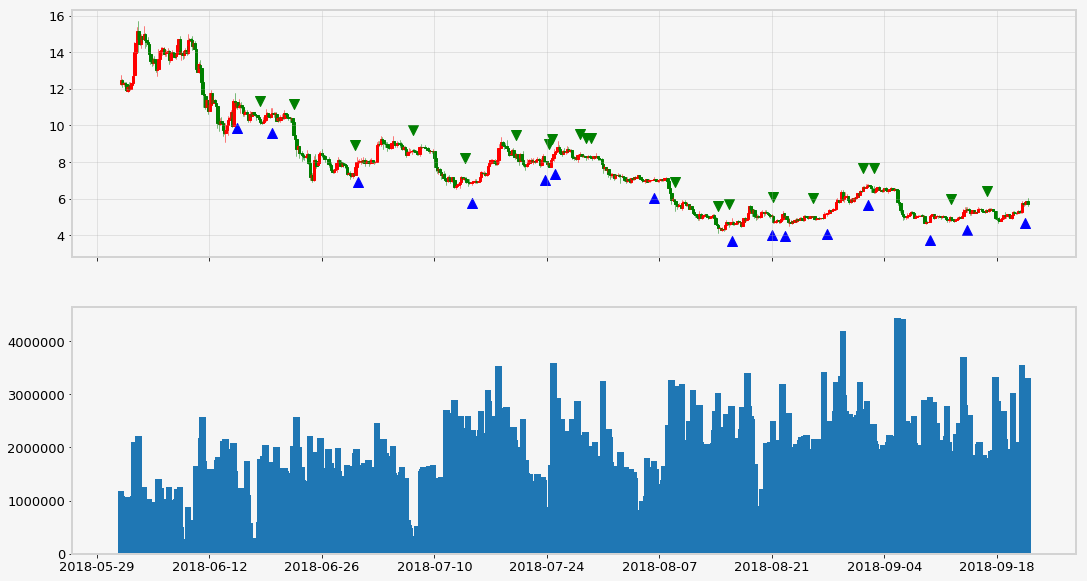

In [17]:
# 5、k线图中的进出场时刻 
data4H = Time_dict.set_index('datetime')
data4H['candleTime'] = list(map(date2num, data4H.index))
candle = data4H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

longsignal = dv.get_ts('long', date_type='datetime')
shortsignal = dv.get_ts('short', date_type='datetime')

longX = longsignal[longsignal['EOSUSDT:binance']==2].index
longY = data4H.loc[longX].low-1
shortX = shortsignal[shortsignal['EOSUSDT:binance']==-2].index
shortY = data4H.loc[shortX].high+1

draw_candle_signal(candle,longX,longY,shortX,shortY)

In [18]:
# 6、计算绩效
tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='ARJ_PSYJ_mastatistic')
TimingSignal(tdMaStatistic, dv, 100, 0.15, 0.7)
tdMaStatistic.create_event_report(sig_type="long")
tdMaStatistic.create_event_report(sig_type="short")
tdMaStatistic.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              2.295 -3.323   0.273
p-value             0.061  0.016   0.789
mean                0.086 -0.070   0.008
std                 0.092  0.051   0.108
info_ratio          0.937 -1.357   0.076
skewness            0.993 -0.404   0.827
kurtosis           -0.655 -1.125   0.391
pct5                0.012 -0.147  -0.137
pct25               0.022 -0.105  -0.050
pct50               0.028 -0.056   0.004
pct75               0.129 -0.033   0.028
pct95               0.240 -0.010   0.213
occurance           7.000  7.000  14.000
win_ratio             NaN    NaN   0.500
win_mean/loss_mean    NaN    NaN   1.234
*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              6.212  -4.198   1.587
p-value             0.000   0.002   0.129
mean  